<a href="https://colab.research.google.com/github/RayGone/DeepWeeds/blob/main/MobileNet/V3S/Experiment3.0-GA-withPooler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'deepweeds:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4419124%2F7615277%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T092857Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D08451cc0957e5deb6789712b016635cc7424585d771f6970d0da1e7f49881c284a2df578a5ae00274e7c779179790e433c07338b27b4077968b3f3cbd6b33c408fff1cd697d7946acd6bbe7cbfbd4ffa6282b1c8b95b6de99860a2f51eade19b7471c574f5b5c9a9ee51545df5a4a61294c08bddb1674c763a5a6c81eefe29502a1585a727f159f9887ded2d822865bcd574ea112dcac716f58249a232f0dfc5b7006347bcf7bae7e4b8ed3a5d9df8bb4bf28c6a6fb949155096994ea42688b36486e462358430525e1fccc7fa5f572c416a3d3571158c66e7e385a53ecb49cf60b3524506eeaccb526b459955c9aa6e1de90d93bb286d7a20fc20eb3df0000b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 493010412 bytes downloaded
Downloaded and uncompressed: deepweeds
Data source import complete.


# DeepWeeds - MobileNet

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed, True)

In [3]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [4]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [5]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [6]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [7]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [8]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [9]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


## Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [10]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Creating Dateset ImageGenerator

In [12]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10506 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.


### Displaying Images

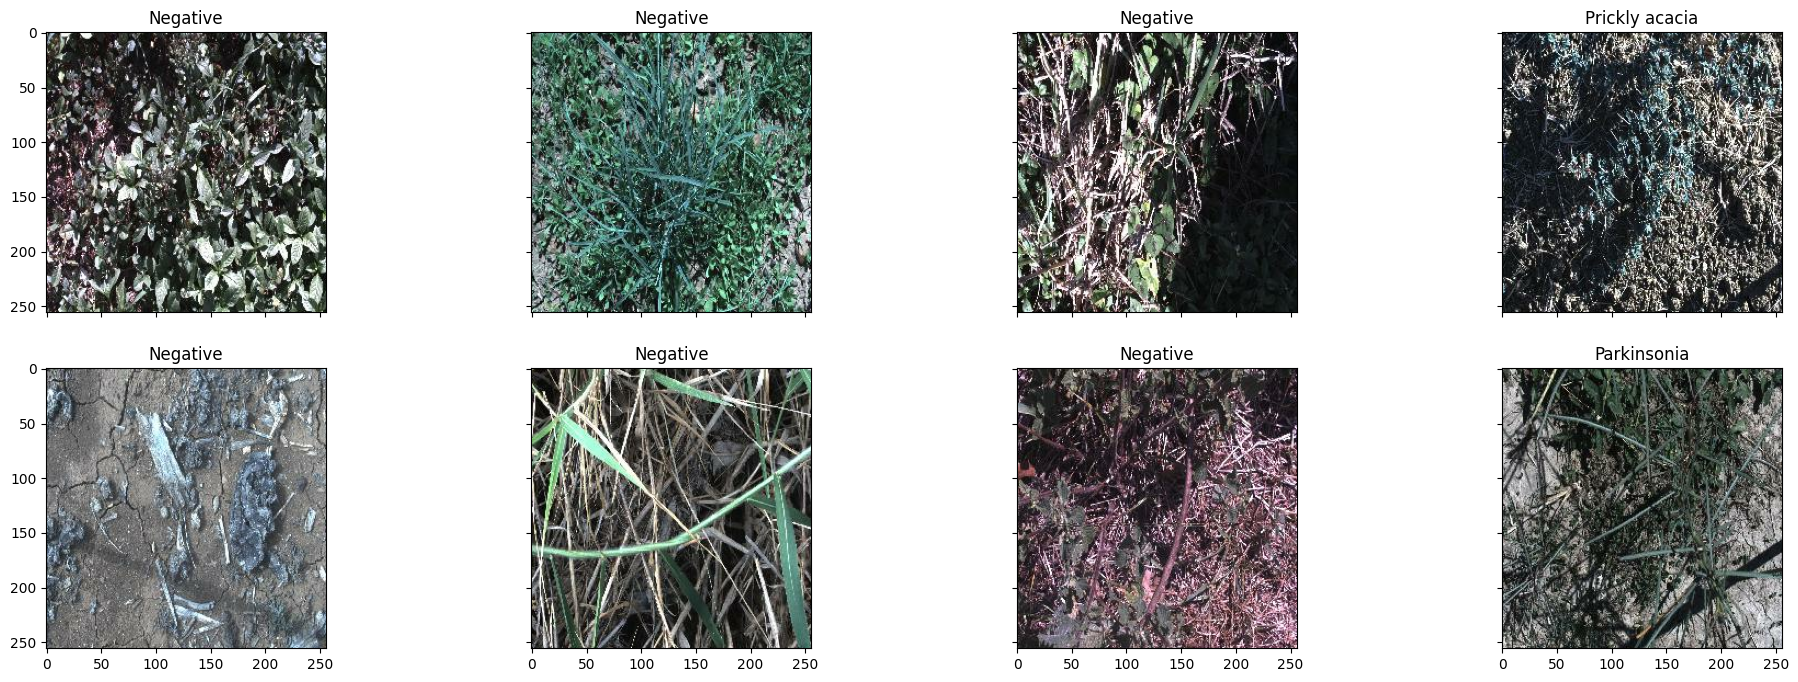

In [14]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [15]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

class SpatialMaxPooling2D(tf.keras.layers.Layer):
  def __init__(self,pool_size=2,stride=None,padding='valid',**kwargs):
    super(SpatialMaxPooling2D,self).__init__(**kwargs)
    self.pool_size = pool_size
    self.stride = stride
    self.padding = padding
    if stride is None:
      self.stride = self.pool_size

    self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding)
    self.permute_forward = tf.keras.layers.Permute((3,1,2))
    self.permute_backward = tf.keras.layers.Permute((2,3,1))

  def build(self,input_shape):
    self.reshape_forward = tf.keras.layers.Reshape((input_shape[-1],-1))
    self.reshape_backward= tf.keras.layers.Reshape((-1, input_shape[1], input_shape[2]))

  def call(self,x, training):
    x = self.permute_forward(x)
    x = self.reshape_forward(x)
    x = self.max(x)
    x = self.reshape_backward(x)
    x = self.permute_backward(x)
    return x

## Building MobileNet Model

In [16]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet')
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet')
    mobilenet.trainable = True

    base_model =  keras.Model(inputs=mobilenet.layers[0].input, outputs=mobilenet.layers[-11].output, name = mobilenet.name+"_base_")
    base_model.trainable = True

    pooler = mobilenet.layers[-9]

    return base_model , pooler

def buildModel():
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    base_model.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)

    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = pooler(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(9, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [17]:
model = buildModel()
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Base Model: MobilenetV3small_base_
229
Model: "CottonWeed15-MobilenetV3small_base_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 PP_Rescale (Rescaling)      (None, 256, 256, 3)       0         
                                                                 
 PP_Resize (Resizing)        (None, 224, 224, 3)       0         
                                                                 
 augment_pipeline (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 MobilenetV3small_base_ (Fu  (None, 7, 7, 576)         939120    
 nctional)                                                 

## Trial 1 - FineTuning

In [18]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 200

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-4,  weight_decay=3e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/200
329/329 [==============================] - 69s 110ms/step - loss: 1.5910 - accuracy: 0.5012 - val_loss: 1.0373 - val_accuracy: 0.6305 - lr: 1.0000e-04
Epoch 2/200
329/329 [==============================] - 31s 93ms/step - loss: 1.1598 - accuracy: 0.5890 - val_loss: 0.8812 - val_accuracy: 0.6822 - lr: 1.0000e-04
Epoch 3/200
329/329 [==============================] - 32s 97ms/step - loss: 1.0250 - accuracy: 0.6379 - val_loss: 0.7527 - val_accuracy: 0.7310 - lr: 1.0000e-04
Epoch 4/200
329/329 [==============================] - 30s 91ms/step - loss: 0.8999 - accuracy: 0.6826 - val_loss: 0.6863 - val_accuracy: 0.7550 - lr: 1.0000e-04
Epoch 5/200
329/329 [==============================] - 31s 92ms/step - loss: 0.8299 - accuracy: 0.7045 - val_loss: 0.6357 - val_accuracy: 0.7744 - lr: 1.0000e-04
Epoch 6/200
329/329 [==============================] - 32s 95ms/step - loss: 0.7699 - accuracy: 0.7244 - val_loss: 0.6001 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 7/200
329/329 [======

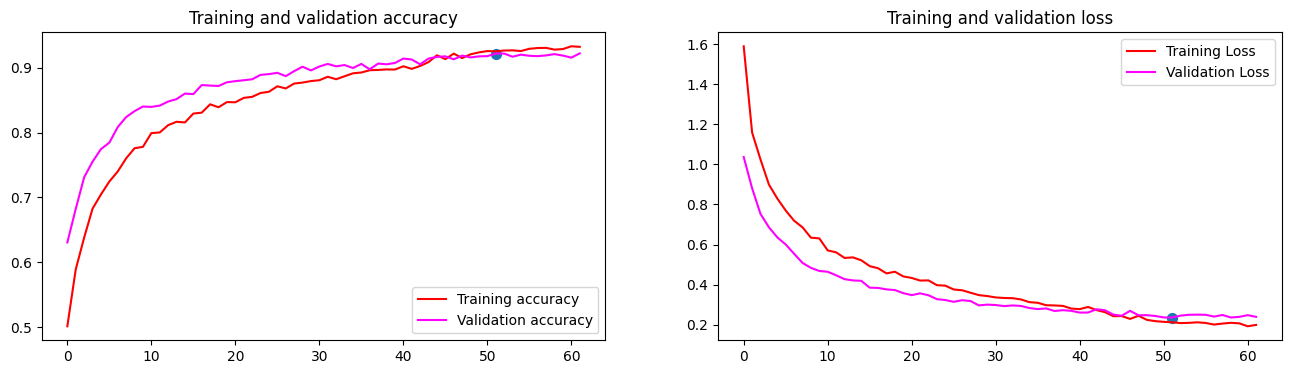

CPU times: user 41min 11s, sys: 3min 9s, total: 44min 20s
Wall time: 34min 22s


In [19]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
110/110 [==============================] - 4s 36ms/step - loss: 0.2479 - accuracy: 0.9206
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.80734   0.78222   0.79458       225
       Lantana    0.90148   0.86321   0.88193       212
   Parkinsonia    0.93897   0.97087   0.95465       206
    Parthenium    0.92000   0.89756   0.90864       205
Prickly acacia    0.91121   0.91549   0.91335       213
   Rubber vine    0.86697   0.93564   0.90000       202
     Siam weed    0.92195   0.87907   0.90000       215
    Snake weed    0.82564   0.79310   0.80905       203
      Negative    0.94172   0.94948   0.94558      1821

      accuracy                        0.91548      3502
     macro avg    0.89281   0.88741   0.88975      3502
  weighted avg    0.91511   0.91548   0.91510      3502


                False Positive Rate  Accuracy
Chinee apple               0.012817  0.782222
Lantana                    0.006079  0.863208
Parkinsonia                0.003944  0.970874
Parthenium                 0.004853  0.897561
Prickly acacia    

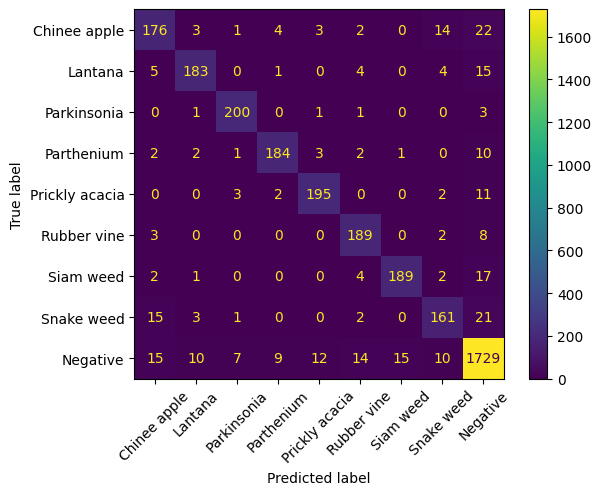

In [20]:
a, b = eval_model(model, validation_generator)

model.evaluate
110/110 [==============================] - 5s 49ms/step - loss: 3.0848 - accuracy: 0.4913
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.13953   0.08000   0.10169       225
       Lantana    0.20833   0.07042   0.10526       213
   Parkinsonia    0.36364   0.07767   0.12800       206
    Parthenium    0.20968   0.06373   0.09774       204
Prickly acacia    0.25000   0.06604   0.10448       212
   Rubber vine    0.25843   0.11386   0.15808       202
     Siam weed    0.30612   0.06977   0.11364       215
    Snake weed    0.20000   0.10345   0.13636       203
      Negative    0.54750   0.87040   0.67218      1821

      accuracy                        0.49129      3501
     macro avg    0.27591   0.16837   0.17972      3501
  weighted avg    0.40047   0.49129   0.40613      3501


                False Positive Rate  Accuracy
Chinee apple               0.033883  0.080000
Lantana                    0.017336  0.070423
Parkinsonia                0.008498  0.077670
Parthenium                 0.014862  0.063725
Prickly acacia    

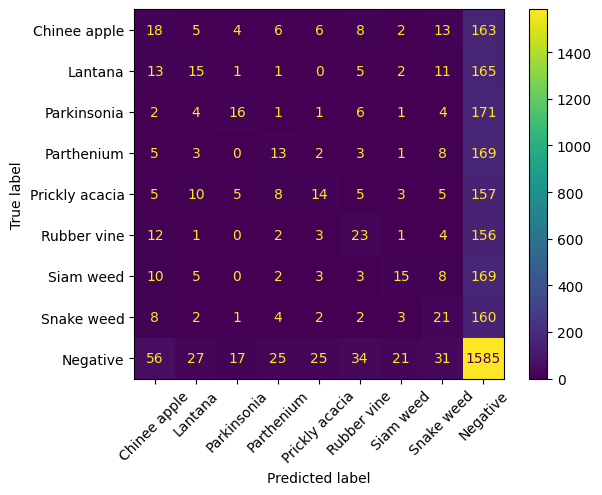

In [21]:
a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small_base_
Epoch 1/200
329/329 [==============================] - 25s 57ms/step - loss: 0.3686 - accuracy: 0.8742 - val_loss: 0.2741 - val_accuracy: 0.9083 - lr: 1.0000e-06
Epoch 2/200
329/329 [==============================] - 18s 54ms/step - loss: 0.3573 - accuracy: 0.8769 - val_loss: 0.2733 - val_accuracy: 0.9095 - lr: 1.0000e-06
Epoch 3/200
329/329 [==============================] - 18s 53ms/step - loss: 0.3587 - accuracy: 0.8769 - val_loss: 0.2732 - val_accuracy: 0.9095 - lr: 1.0000e-06
Epoch 4/200
329/329 [==============================] - 18s 54ms/step - loss: 0.3489 - accuracy: 0.8816 - val_loss: 0.2735 - val_accuracy: 0.9086 - lr: 1.0000e-06
Epoch 5/200
329/329 [==============================] - 19s 58ms/step - loss: 0.3462 - accuracy: 0.8793 - val_loss: 0.2736 - val_accuracy: 0.9089 - lr: 1.0000e-06
Epoch 6/200
329/329 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.8857
Epoch 6: ReduceLROnPlateau reducing learning rate to 5e

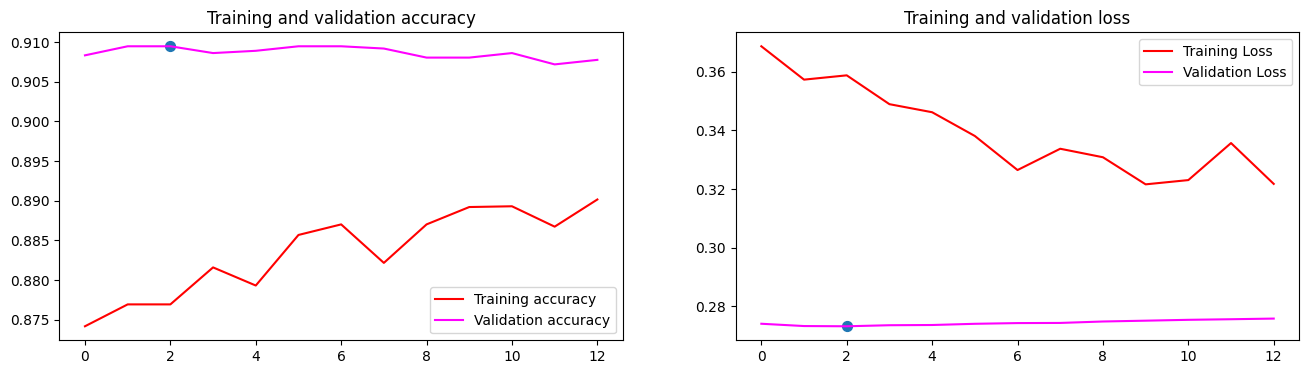

In [22]:
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)

for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=5e-3),
  metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=4, verbose=1, min_lr=5e-7)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

## Evaluations

Total Epochs: range(0, 75)


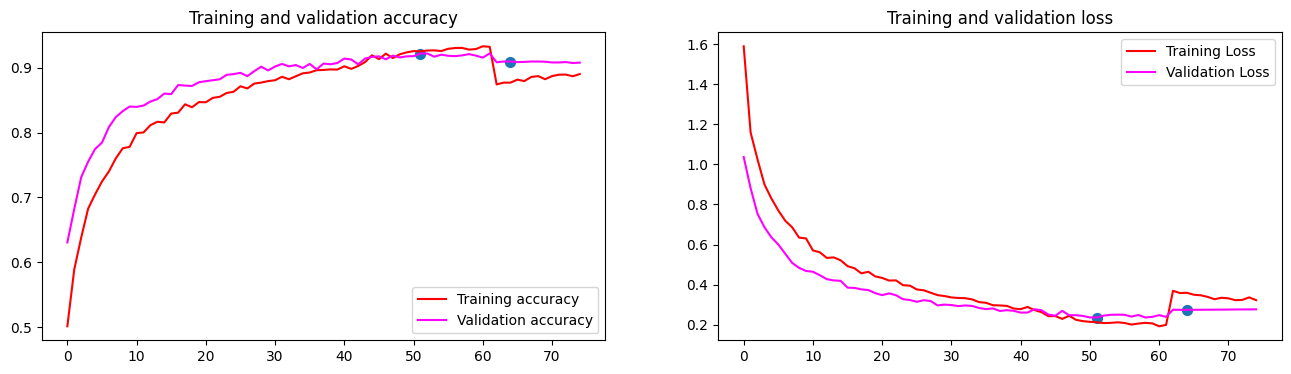

In [23]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 62)


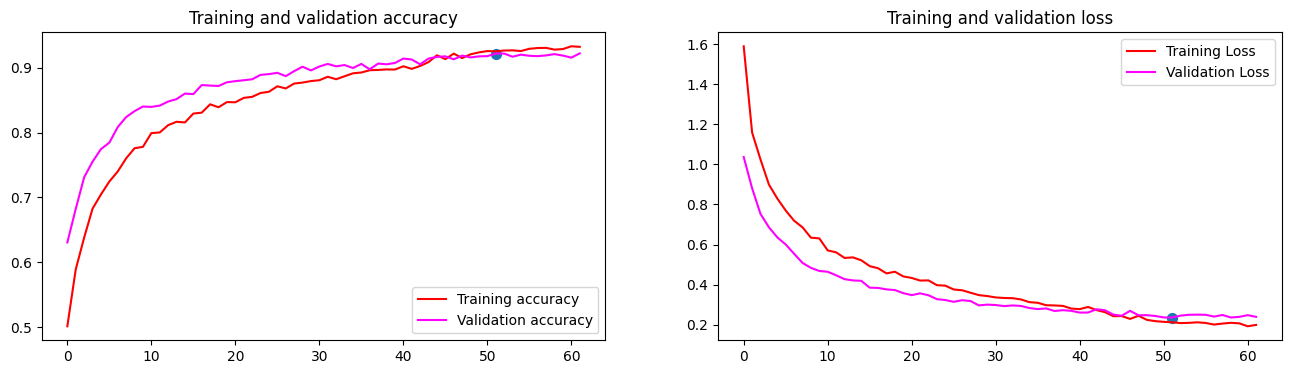

Total Epochs: range(0, 13)


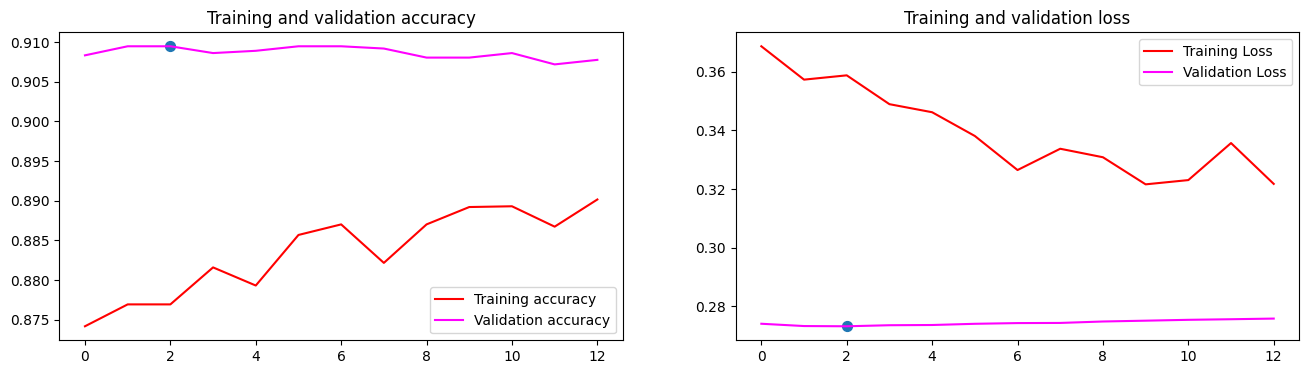

In [24]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

model.evaluate
110/110 [==============================] - 5s 43ms/step - loss: 0.2732 - accuracy: 0.9095
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81818   0.80000   0.80899       225
       Lantana    0.96629   0.81132   0.88205       212
   Parkinsonia    0.94271   0.87864   0.90955       206
    Parthenium    0.78049   0.93659   0.85144       205
Prickly acacia    0.86099   0.90141   0.88073       213
   Rubber vine    0.91787   0.94059   0.92910       202
     Siam weed    0.93780   0.91163   0.92453       215
    Snake weed    0.77626   0.83744   0.80569       203
      Negative    0.94690   0.94014   0.94351      1821

      accuracy                        0.90948      3502
     macro avg    0.88305   0.88420   0.88173      3502
  weighted avg    0.91247   0.90948   0.90996      3502


                False Positive Rate  Accuracy
Chinee apple               0.012206  0.800000
Lantana                    0.001824  0.811321
Parkinsonia                0.003337  0.878641
Parthenium                 0.016379  0.936585
Prickly acacia    

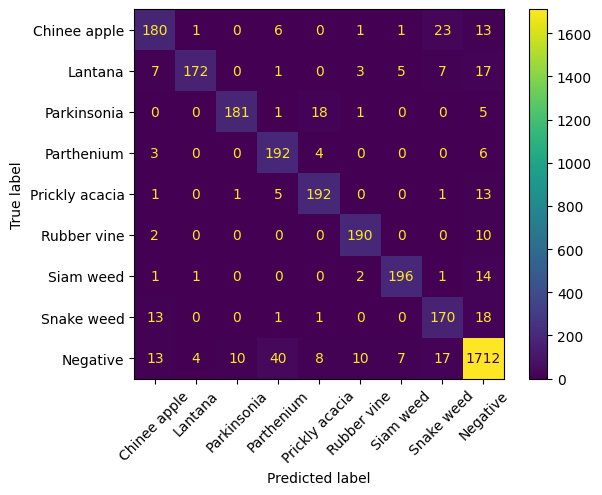

In [25]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

### Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
110/110 [==============================] - 5s 47ms/step - loss: 0.2669 - accuracy: 0.9169
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.82969   0.84444   0.83700       225
       Lantana    0.96316   0.85915   0.90819       213
   Parkinsonia    0.92893   0.88835   0.90819       206
    Parthenium    0.79184   0.95098   0.86414       204
Prickly acacia    0.83262   0.91509   0.87191       212
   Rubber vine    0.94000   0.93069   0.93532       202
     Siam weed    0.95960   0.88372   0.92010       215
    Snake weed    0.85204   0.82266   0.83709       203
      Negative    0.94926   0.94509   0.94717      1821

      accuracy                        0.91688      3501
     macro avg    0.89413   0.89335   0.89212      3501
  weighted avg    0.91945   0.91688   0.91730      3501


                False Positive Rate  Accuracy
Chinee apple               0.011905  0.844444
Lantana                    0.002129  0.859155
Parkinsonia                0.004249  0.888350
Parthenium                 0.015469  0.950980
Prickly acacia    

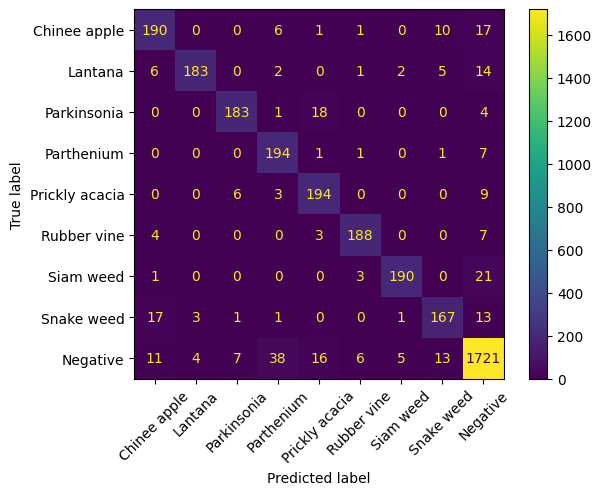

In [26]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

### Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.76265   0.87111   0.81328       225
       Lantana    0.88679   0.88263   0.88471       213
   Parkinsonia    0.93367   0.88835   0.91045       206
    Parthenium    0.79098   0.94608   0.86161       204
Prickly acacia    0.78824   0.94811   0.86081       212
   Rubber vine    0.95431   0.93069   0.94236       202
     Siam weed    0.94118   0.89302   0.91647       215
    Snake weed    0.85279   0.82759   0.84000       203
      Negative    0.96435   0.92092   0.94213      1821

      accuracy                        0.91003      3501
     macro avg    0.87500   0.90095   0.88576      3501
  weighted avg    0.91563   0.91003   0.91139      3501


                False Positive Rate  Accuracy
Chinee apple               0.018620  0.871111
Lantana            

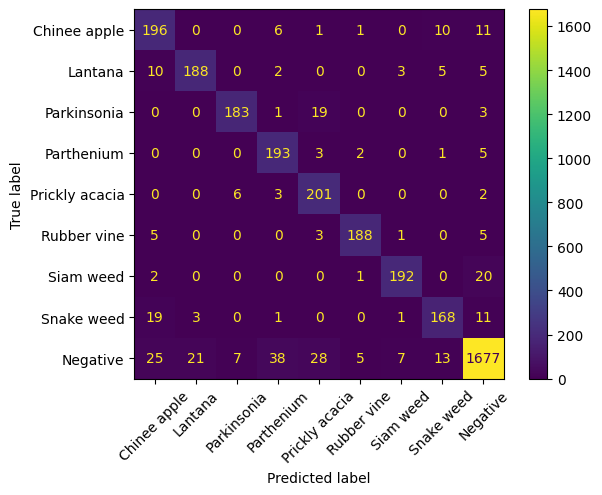

In [27]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b, 0.11)